# Car Insurance Sales Prediction

## 1. Problem Statement
___

The aim of this project is to predict whether a health insurance customer from past year would be interested in vehicle insurance, by analyzing customer features such as gender, age, driving license, region, previous insurance history, vehicle age, and annual premium price. The project also aims to find out the set of variables that has the most impact on the customers' interest in vehicle insurance.

## 2. Data Import and Check
___

### Libraries needed

In [1]:
# libraries for visualizations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# libraries for data preprocessing
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn import preprocessing

In [3]:
# libraries for model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [4]:
# libraries for model performance
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, top_k_accuracy_score, roc_curve,auc,RocCurveDisplay,confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve,  silhouette_score
from sklearn.model_selection import RandomizedSearchCV

In [66]:
# ignore warning
import warnings
warnings.filterwarnings('ignore')

### Data import

In [5]:
# train dataset
train = pd.read_csv(r"C:\Users\eunbi\Desktop\DS\Car Insurance Prediction\health_insurance.csv")
train.shape

(381109, 12)

In [6]:
# test dataset
test = pd.read_csv(r"C:\Users\eunbi\Desktop\DS\Car Insurance Prediction\health_insurance_test.csv")
test.shape

(127037, 11)

### Data check

In [7]:
# first five rows of the dataset
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [8]:
# dataset information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:
# numerical variables
train[['Age', 'Annual_Premium', 'Vintage']].describe().round(1)

,Age,Annual_Premium,Vintage
count,381109.0,381109.0,381109.0
mean,38.8,30564.4,154.3
std,15.5,17213.2,83.7
min,20.0,2630.0,10.0
25%,25.0,24405.0,82.0
50%,36.0,31669.0,154.0
75%,49.0,39400.0,227.0
max,85.0,540165.0,299.0


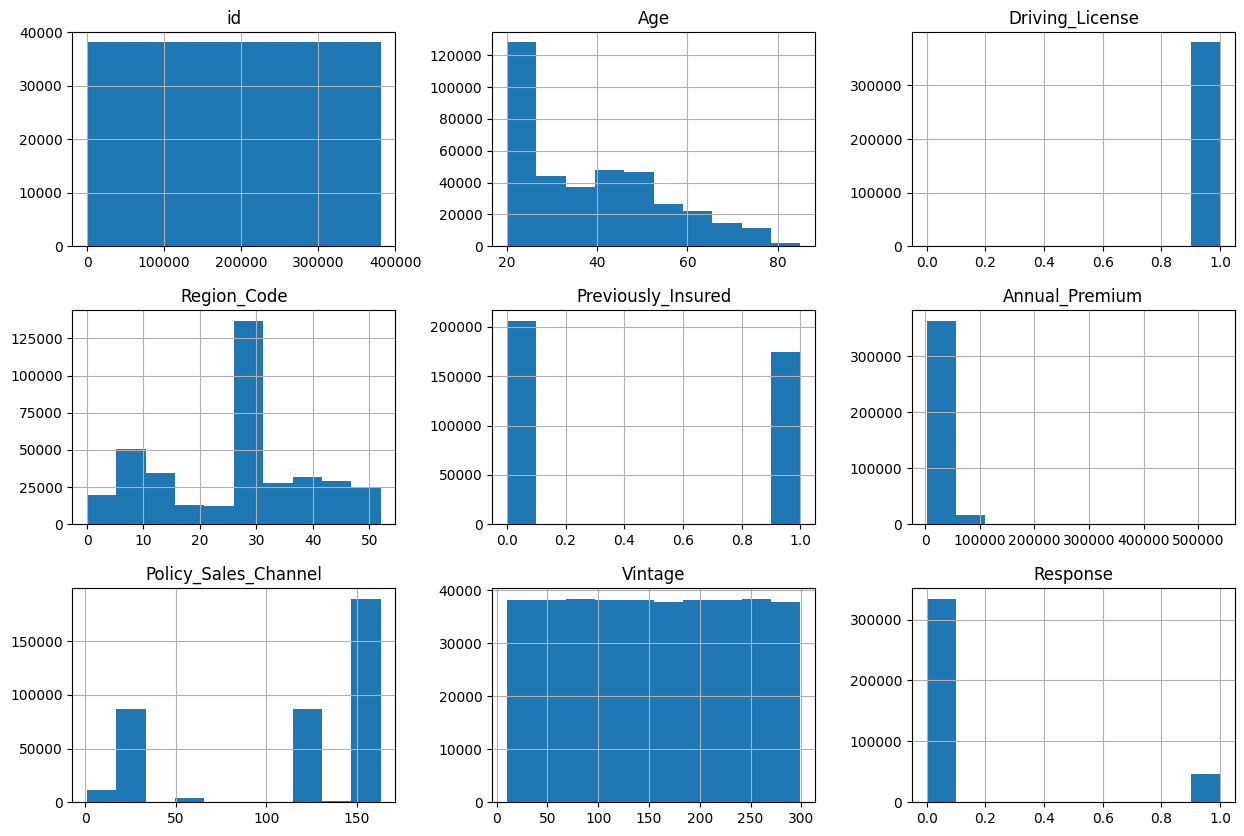

In [10]:
# histograms
train.hist(figsize=(15,10))
plt.show()

* The dataset is highly imbalanced
* We have 12 columns including Response and id column. We will drop id column since it is unnecessary.
* Our response variable is binary variable. So, we will have to build a logistic regression model.
* We will treat Region_Code, Policy_Sales_Channel and Vintage as categorical variables.
* We will also create age group variable as well.

## 3. Data Pre-processing
___

### Check for missing values

In [11]:
# missing values
train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### Check for outliers

* Annual_Premium seems to be highly right skewed and have large variability. This could be due to outliers.

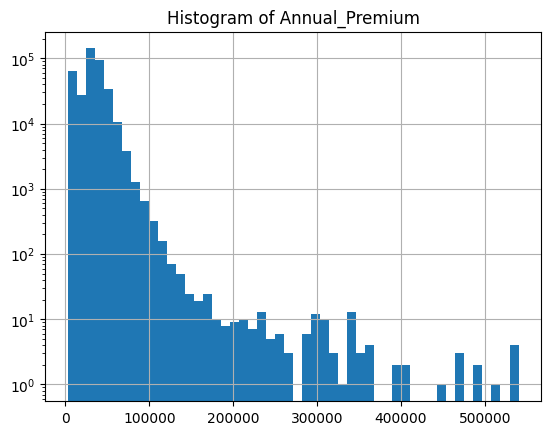

In [12]:
# histogram
train['Annual_Premium'].hist(bins = 50)
plt.yscale('log')
plt.title('Histogram of Annual_Premium')
plt.show()

In [13]:
train[train['Annual_Premium'] > 100000.0].shape

(778, 12)

* The annual premium paid by the largest number of customers is 2630.
* Only 778 customers pay annual premium of over 100,000.
* Only 3 customers pay annual premium of over 500,000. Should we consider these values as outliers?
* If we subtract 1.5 x IQR from the first quartile, any data values that are less than this number are considered outliers. Similarly, if we add 1.5 x IQR to the third quartile, any data values that are greater than this number are considered outliers.

In [14]:
# IQR Range
IQR = 39400.0 - 24405.0
lower = 24405.0 - (IQR * 1.5)
upper = 39400.0 + (IQR * 1.5)
print(lower, upper)

1912.5 61892.5


In [15]:
train = train[train['Annual_Premium'] <= upper].copy()

## 4. Feature Engineering
___

### Add Age Group variable

In [16]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
train['Age_Group'] = pd.cut(train.Age, bins, labels = labels, include_lowest = True)

test['Age_Group'] = pd.cut(test.Age, bins, labels = labels,include_lowest = True)

train[['Age','Age_Group']].head(5)

,Age,Age_Group
0,44,40-49
1,76,70-79
2,47,40-49
3,21,20-29
4,29,20-29


### Convert data types

In [17]:
cat_cols = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel', 'Age_Group']
num_cols = ['Age','Annual_Premium', 'Vintage']
data_all = cat_cols + num_cols

In [18]:
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')
train[num_cols] = train[num_cols].astype('int')
test[num_cols] = test[num_cols].astype('int')

In [19]:
train.dtypes

id                         int64
Gender                  category
Age                        int32
Driving_License         category
Region_Code             category
Previously_Insured      category
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium             int32
Policy_Sales_Channel    category
Vintage                    int32
Response                   int64
Age_Group               category
dtype: object

In [20]:
train.shape

(370789, 13)

### Encode categorical variables

* OrdinalEncoder/LabelEncoder: When order is important for categorical variables, it's important to use sklearn OrdinalEncoder or LabelEncoder. eg. cold, warm, hot

* One Hot Encoding: When order is NOT important we can use sklearn OneHotEncoder or pandas get_dummies function. eg. Gender is an example Female, Male

* There are two rows in test data which has different Policy Sales Channel that do not exist in train data. It's 141 and 142. We will replace them with 140.

In [21]:
train_df = train.copy()
test_df = test.copy()
id_col = test_df.id
train_df.drop(columns = ['id'], inplace = True)
test_df.drop(columns = ['id'], inplace = True)
train_df['Vehicle_Age_num'] = ''
test_df['Vehicle_Age_num'] = ''
train_df.loc[train_df['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age_num'] = 0
train_df.loc[train_df['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age_num'] = 1
train_df.loc[train_df['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age_num'] = 2
test_df.loc[test_df['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age_num'] = 0
test_df.loc[test_df['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age_num'] = 1
test_df.loc[test_df['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age_num'] = 2

In [22]:
oe = OrdinalEncoder()
train_df[cat_cols +  ['Vehicle_Age_num']] = oe.fit_transform(train_df[cat_cols + ['Vehicle_Age_num']])

# there is 2 unknown new Policy_Sales_Channel values in test 141 and 142
# we replace them with 140

test_df.loc[test['Policy_Sales_Channel'] == 141.0, 'Policy_Sales_Channel'] = 140.0
test_df.loc[test['Policy_Sales_Channel'] == 142.0, 'Policy_Sales_Channel'] = 140.0

test_df[cat_cols] = oe.fit_transform(test_df[cat_cols])

In [23]:
cat_cols_new = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age_num','Vehicle_Damage','Policy_Sales_Channel', 'Age_Group']
data_all_new = cat_cols_new + num_cols
train_df.drop(columns=['Vehicle_Age'], inplace=True)
test_df.drop(columns=['Vehicle_Age'], inplace=True)

In [24]:
train_df.shape

(370789, 12)

### Save the dataframe as csv file

In [25]:
#train_df.to_csv('car_train_df.csv', index=False)

## 5. Exploratory Data Analysis
___

### Target variable (Response)

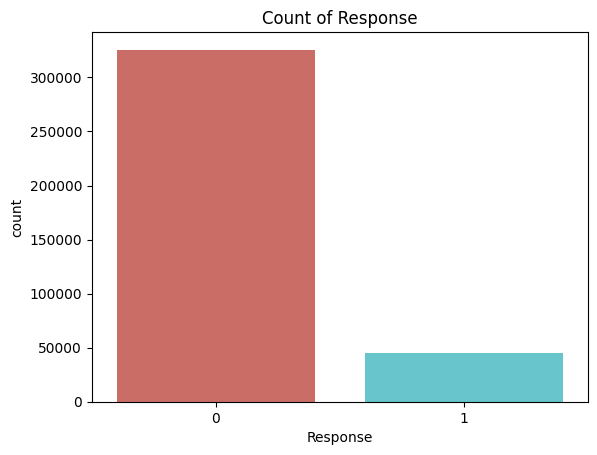

In [26]:
ax = sns.countplot(train, x = 'Response', palette = 'hls')
plt.title('Count of Response')
plt.show()

In [27]:
train_count = train[['id', 'Response']].groupby(['Response']).count().reset_index().rename(columns = {'id':'Count'})
train_count['Proportion'] = train_count['Count']/train_count['Count'].sum()
train_count

,Response,Count,Proportion
0,0,325634,0.878219
1,1,45155,0.121781


* Majority of the customers responded that they are not interested in vehicle insurance.
* Only 12% of the customers are interested in vehicle insurance.

### Age distribution of customers

In [28]:
train_count = train.loc[train['Response']==1, ['id', 'Age_Group']].groupby(['Age_Group']).count().reset_index().rename(columns = {'id':'Count'})
train_count['Proportion'] = train_count['Count']/train_count['Count'].sum()
train_count

,Age_Group,Count,Proportion
0,20-29,7047,0.156062
1,30-39,11343,0.251201
2,40-49,15474,0.342686
3,50-59,7377,0.163371
4,60-69,2856,0.063249
5,70-79,1052,0.023298
6,80+,6,0.000133


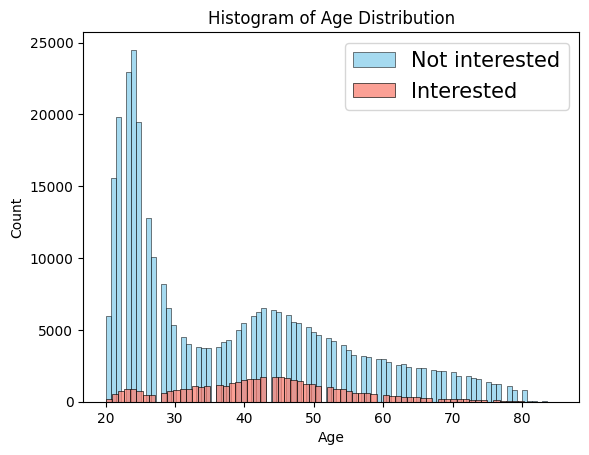

In [29]:
no = train.loc[train['Response'] == 0, 'Age']
yes = train.loc[train['Response'] == 1, 'Age']

sns.histplot(data = no, color = "skyblue", label = "Not interested", kde=False)
sns.histplot(data = yes, color = "salmon", label = "Interested", kde=False)
plt.legend(fontsize = 15)
plt.title('Histogram of Age Distribution')
plt.show()

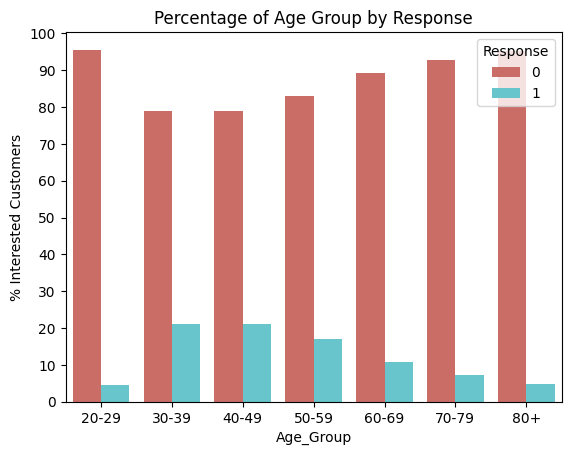

In [30]:
by_age = train.groupby(['Age_Group', 'Response'])['id'].count().reset_index().rename(columns = {'id':'Count'})
by_age['Percentage'] = by_age['Count'] / by_age.groupby('Age_Group')['Count'].transform('sum')*100
sns.barplot(by_age, x = 'Age_Group', y = 'Percentage', hue = 'Response', palette = 'hls')
labels = [i for i in range(0,105,10)]
plt.yticks(labels)
plt.ylabel('% Interested Customers')
plt.title('Percentage of Age Group by Response')
plt.show()

* The age group with the largest number of customer is 20-29 (42.7%). However, this group has the smallest proportion of customers interested in Vehicle insurance.
* The age group of 40-49 has the largest proportion of interested customers (20.1%).
* Among the customers interested in Vehicle insurance, about 34.3% are in 40-49 age range.
* The proportion of the customers interested in Vehicle insurance is smaller in older age groups.

### Age Vs Annual Premium

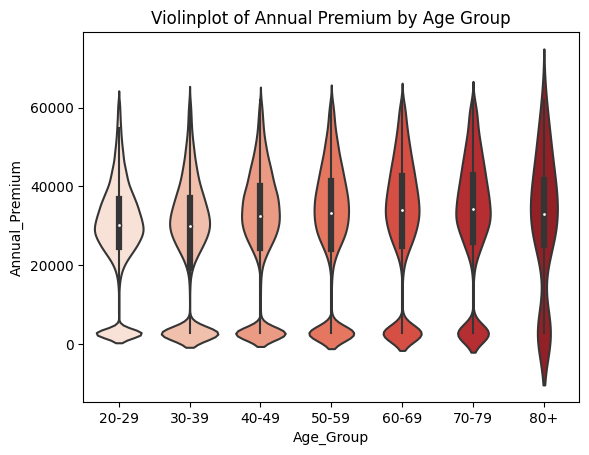

In [34]:
sns.violinplot(train, x = 'Age_Group',y = 'Annual_Premium', palette = 'Reds')
plt.title('Violinplot of Annual Premium by Age Group')
plt.show()

* Older people pay higher annual premium on average.
* The age group of 30-39 has larget variance in annual premium.

### Gender distribution

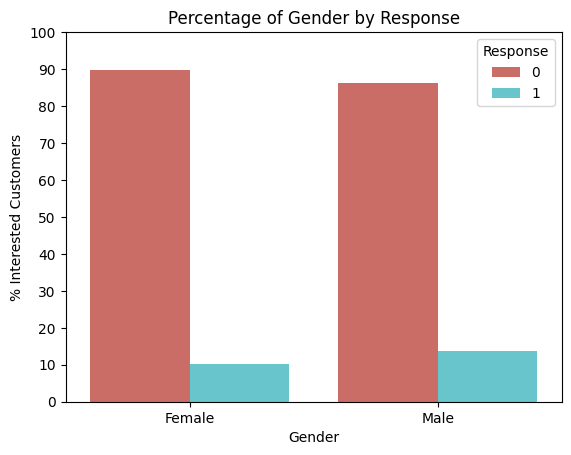

In [35]:
by_gender = train.groupby(['Gender', 'Response'])['id'].count().reset_index().rename(columns = {'id':'Count'})
by_gender['Percentage'] = by_gender['Count'] / by_gender.groupby('Gender')['Count'].transform('sum')*100
sns.barplot(by_gender, x = 'Gender', y = 'Percentage', hue = 'Response', palette = 'hls')
labels = [i for i in range(0,105,10)]
plt.yticks(labels)
plt.ylabel('% Interested Customers')
plt.title('Percentage of Gender by Response')
plt.show()

* About 3% more Male customers are interested in Vehicle insurance than female customers.

### Vehicle Age distribution

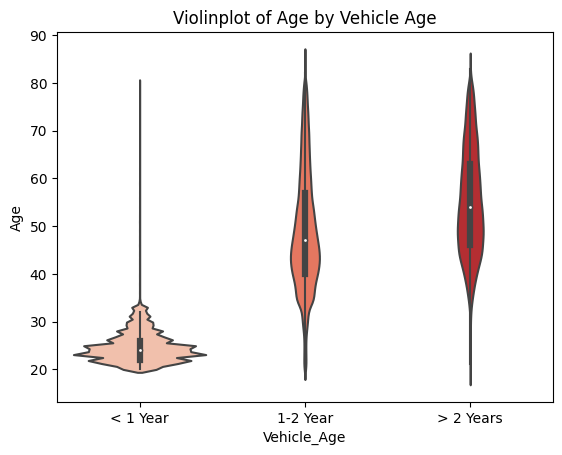

In [40]:
train['Vehicle_Age'] = train['Vehicle_Age'].cat.reorder_categories(['< 1 Year', '1-2 Year', '> 2 Years'], ordered=True)
sns.violinplot(train, x = 'Vehicle_Age', y = 'Age', palette = 'Reds')
plt.title('Violinplot of Age by Vehicle Age')
plt.show()

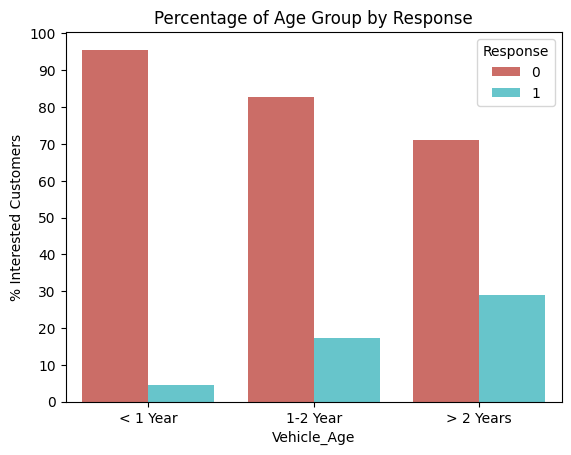

In [41]:
by_vehicle = train.groupby(['Vehicle_Age', 'Response'])['id'].count().reset_index().rename(columns = {'id':'Count'})
by_vehicle['Percentage'] = by_vehicle['Count'] / by_vehicle.groupby('Vehicle_Age')['Count'].transform('sum')*100
sns.barplot(by_vehicle, x = 'Vehicle_Age', y = 'Percentage', hue = 'Response', palette = 'hls')
labels = [i for i in range(0,105,10)]
plt.yticks(labels)
plt.ylabel('% Interested Customers')
plt.title('Percentage of Age Group by Response')
plt.show()

* Older customers are tend to have older vehicles.
* The older the customer's vehicles are, the more they are interested in Vehicle insurance.
* It seems that vehicle age has a positive effect on response.

### Vehicle damage / Response relationship

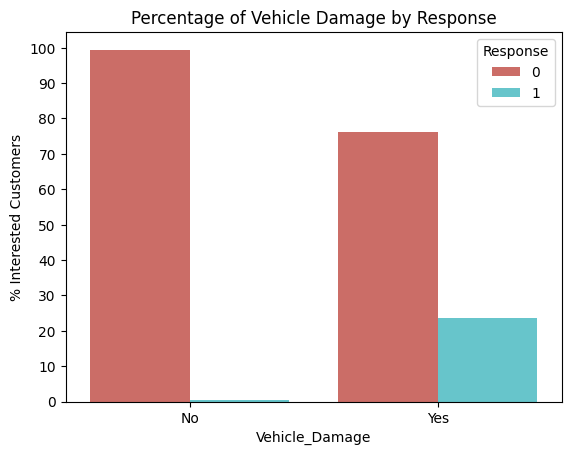

In [42]:
by_damage = train.groupby(['Vehicle_Damage', 'Response'])['id'].count().reset_index().rename(columns = {'id':'Count'})
by_damage['Percentage'] = by_damage['Count'] / by_damage.groupby('Vehicle_Damage')['Count'].transform('sum')*100
sns.barplot(by_damage, x = 'Vehicle_Damage', y = 'Percentage', hue = 'Response', palette = 'hls')
labels = [i for i in range(0,105,10)]
plt.yticks(labels)
plt.ylabel('% Interested Customers')
plt.title('Percentage of Vehicle Damage by Response')
plt.show()

* Customers who experienced damage on their cars are more interested in Vehicle insurance.
* Only small percentage of customers who do not have car damage is interested in Vehicle insurance.

### Policy Sales Channel distribution

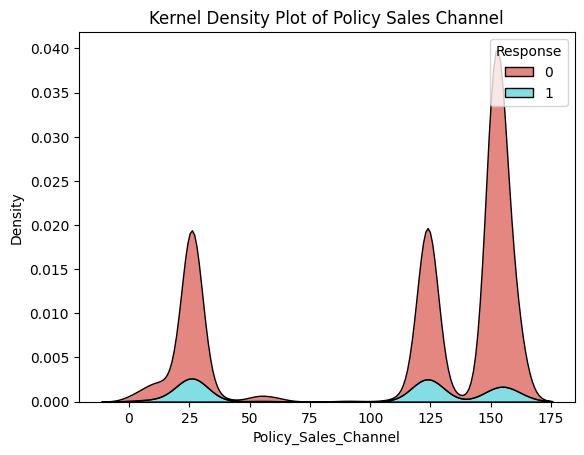

In [43]:
train_1 = train.copy()
train_1['Policy_Sales_Channel'] = train_1['Policy_Sales_Channel'].astype('int')
sns.kdeplot(train_1, x = 'Policy_Sales_Channel', hue = 'Response', multiple='stack', palette = 'hls')
plt.title('Kernel Density Plot of Policy Sales Channel')
plt.show()

* The major Policy Sales Channels are same for both the customers interested in Vehicle insurance and those who are not.
* The top 3 Policy Sales Channels are 26, 124 and 152.

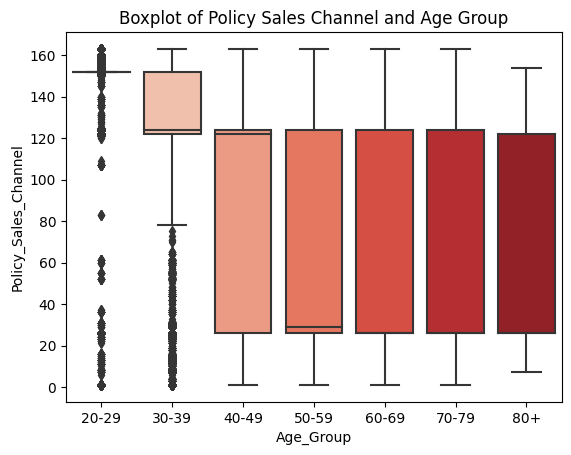

In [44]:
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype('int')
sns.boxplot(train, x = 'Age_Group', y = 'Policy_Sales_Channel', palette='Reds')
plt.title('Boxplot of Policy Sales Channel and Age Group')
plt.show()

* Younger age groups seem to prefer higher Policy Sales Channe code, while older age groups seem to prefer Lower Policy Channel code.

### Vintage distribution

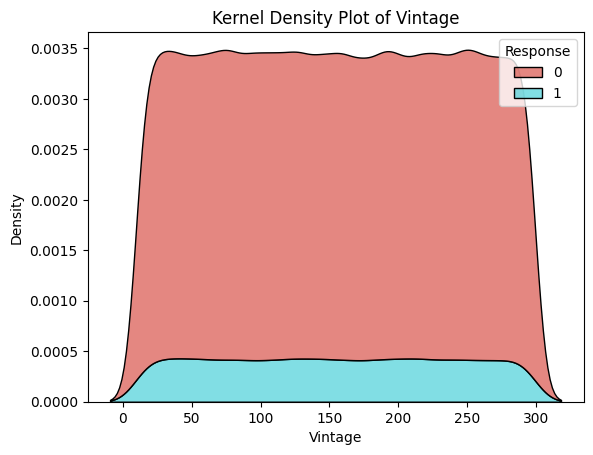

In [45]:
sns.kdeplot(train, x = 'Vintage', hue = 'Response', multiple='stack', palette = 'hls')
plt.title('Kernel Density Plot of Vintage')
plt.show()

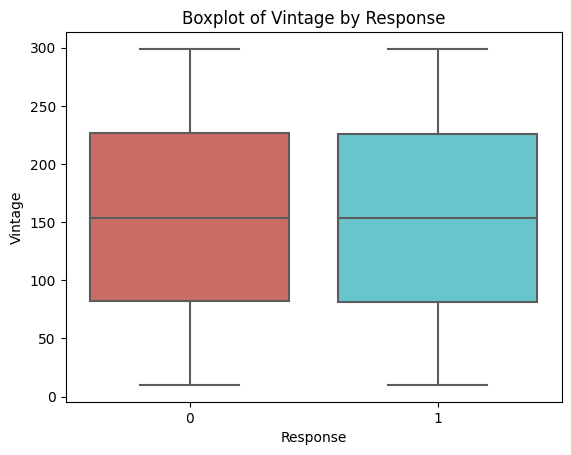

In [46]:
sns.boxplot(train, x = 'Response', y = 'Vintage', palette = 'hls')
plt.title('Boxplot of Vintage by Response')
plt.show()

* Vintage seem to be evenly distributed.
* There seems to be no difference in the average number of days customers have been associated with the company between those who are interested in Vehicle insurance and those who are not.

### Correlation Analysis

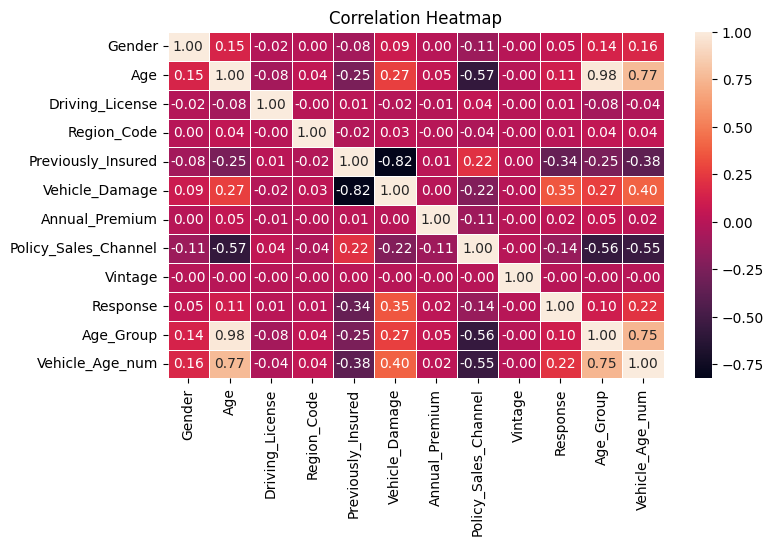

In [47]:
plt.figure(figsize=(8, 4.5))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

* There is a moderate negative correlation(-0.57) between Age and Policy Sales Channel. Older age group prefers to be outreached by lower Policy Sales Channel code.
* There is a fair positive correlation (0.75) between Vehicle Age and Age. Older age group has older vehicles.

## 6 Feature Selection
___

### Data Split

In [48]:
data_all

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel',
 'Age_Group',
 'Age',
 'Annual_Premium',
 'Vintage']

In [49]:
test_df = test_df[data_all_new]
x = train_df[data_all_new]
y = train_df['Response']

# Perform 80/20 data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)

### Standardization

In [50]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
test_df_scaled = scaler.transform(test_df)

In [51]:
# mutual_info_classif for mixed variables
selector = SelectKBest(score_func = mutual_info_classif, k = 'all')
# fit and transform train set
selector.fit_transform(x_train, y_train)
# transform test set
selector.transform(x_test)

for i in range(len(selector.scores_)):
    print('%s: %f' % (data_all[i], selector.scores_[i]))

Gender: 0.034370
Driving_License: 0.045960
Region_Code: 0.014318
Previously_Insured: 0.114240
Vehicle_Age: 0.040561
Vehicle_Damage: 0.105543
Policy_Sales_Channel: 0.052468
Age_Group: 0.032928
Age: 0.030290
Annual_Premium: 0.003606
Vintage: 0.000000


### Categorical Feature Selection with mutual_info_classif

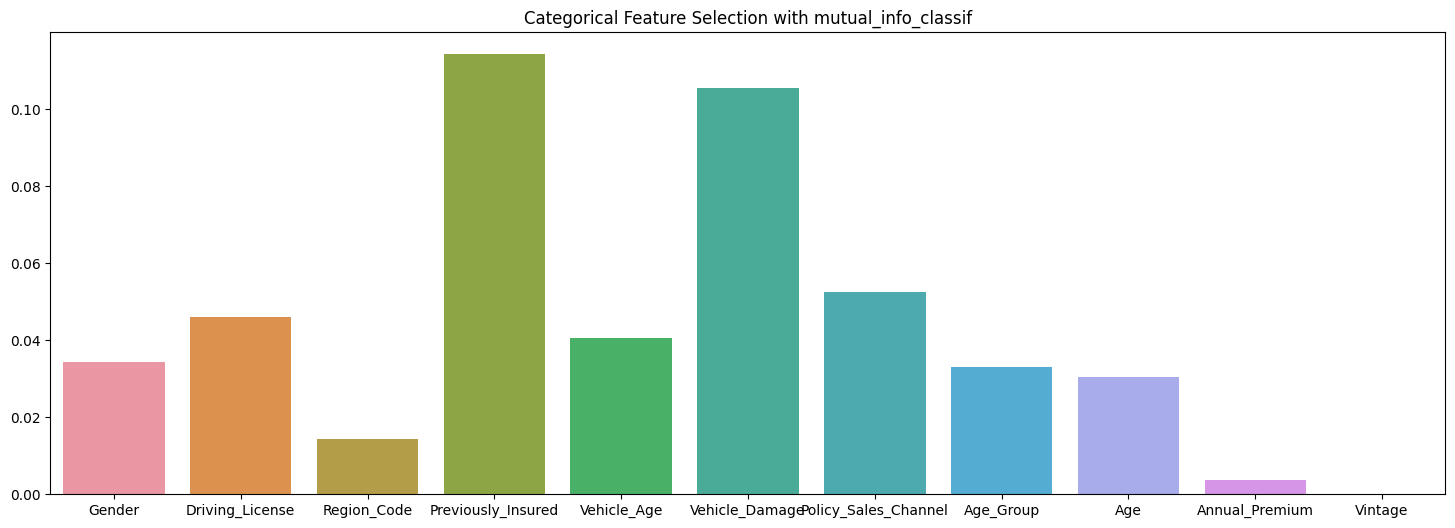

In [52]:
plt.figure(figsize=(18,6))
sns.barplot(x = data_all, y = selector.scores_, orient='v')
plt.title('Categorical Feature Selection with mutual_info_classif')
plt.show()

Depending on the k-scores, we can drop some non useful features from dataset.
* Here we see adding age groups as new features brings small improvement. Age Group have a slightly higher feature importance than Age, so I will drop Age.
* Vintage has the lowest k-score, I will drop it as well.

### Drop Vintage and Age

In [53]:
# drop Vintage and Age Group
x_train.drop(columns = ['Vintage'], inplace = True)
x_test.drop(columns = ['Vintage'], inplace = True)
test_df.drop(columns = ['Vintage'], inplace = True)
x_train.drop(columns = ['Age'], inplace = True)
x_test.drop(columns = ['Age'], inplace = True)
test_df.drop(columns = ['Age'], inplace = True)

### Final dataset

In [54]:
# first five rows of final datset
x_train.head()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age_num,Vehicle_Damage,Policy_Sales_Channel,Age_Group,Annual_Premium
83968,1.0,1.0,8.0,0.0,0.0,1.0,24.0,0.0,2630
216550,1.0,1.0,5.0,1.0,0.0,0.0,145.0,0.0,24924
112985,1.0,1.0,33.0,1.0,0.0,0.0,144.0,0.0,23964
154137,0.0,1.0,8.0,0.0,1.0,1.0,5.0,1.0,45419
325949,0.0,1.0,46.0,1.0,1.0,0.0,119.0,1.0,34602


* Features we are going to use are Gender, Driving License, Region Code, Previously Insured, Vehicle Age, Vehicle Damage, Policy Sales Channel, Age Group and Annual Premium.

## 7. Model Building
___

### Model 1: Logistic Regression Modelling

In [55]:
# model definition
lg = LogisticRegression(random_state = 42)

# model fit
lg.fit(x_train, y_train)

# model prediction
lg_pred = lg.predict(x_test)
lg_proba = lg.predict_proba(x_test)

# model accuracy
print(f'Model Accuracy: {accuracy_score(y_test, lg_pred)}')

# Roc Auc score
print(f'ROC AUC Score: {roc_auc_score(y_test, lg_proba[:, 1]):.4f}')

Model Accuracy: 0.8787685618783763
ROC AUC Score: 0.6054


### Cumulative Gains Curve Chart for Logistic Regression Model

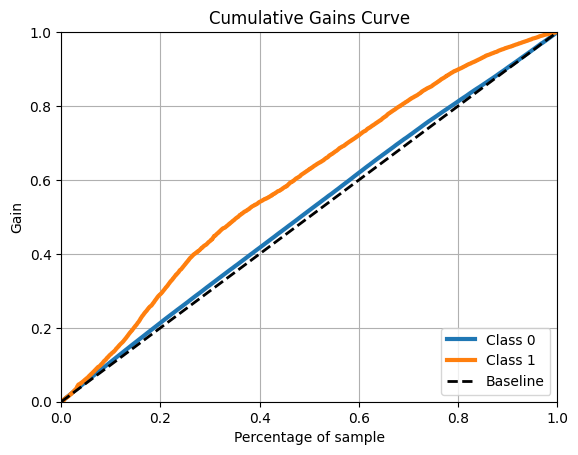

In [56]:
# accumulative gain
plot_cumulative_gain(y_test, lg_proba)
plt.show()

### Model: Random Forest Classifier

In [57]:
# model definition
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)

# model fit
rf.fit(x_train, y_train)

# model prediction
rf_pred = rf.predict(x_test)
rf_proba = rf.predict_proba(x_test)

# model accuracy
print(f'Model Accuracy: {accuracy_score(y_test, rf_pred)}')

# Roc Auc score
print(f'ROC AUC Score: {roc_auc_score(y_test, rf_proba[:, 1]):.4f}')

Model Accuracy: 0.8437737514404099
ROC AUC Score: 0.7964


### Cumulative Gains Curve Chart for Random Forest Model

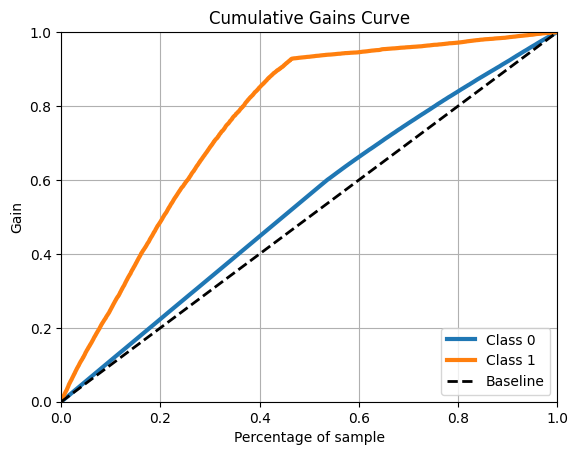

In [58]:
# accumulative gain
plot_cumulative_gain(y_test, rf_proba)
plt.show()

### Model 3: XGBoost Classifier

In [59]:
# model definition
xgb = XGBClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)

# model fit
xgb.fit(x_train, y_train)

# model prediction
xgb_pred = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)

# model accuracy
print(f'Model Accuracy: {accuracy_score(y_test, xgb_pred)}')

# Roc Auc score
print(f'ROC AUC Score: {roc_auc_score(y_test, xgb_proba[:, 1]):.4f}')

Model Accuracy: 0.8772566422307762
ROC AUC Score: 0.8528


### Cumulative Gains Curve Chart for XGBoost Model

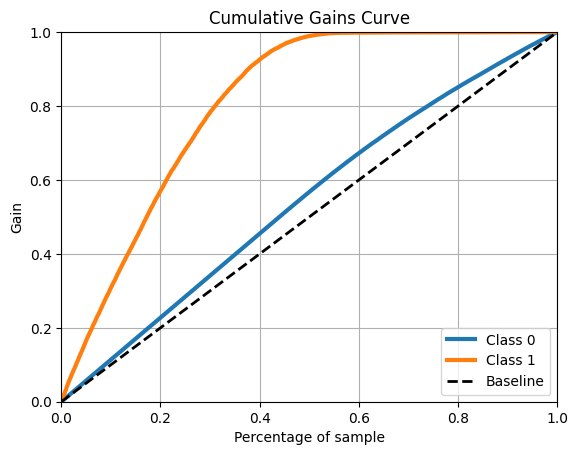

In [60]:
# accumulative gain
plot_cumulative_gain(y_test, xgb_proba)
plt.show()

### Model 4: LGBM Model

In [61]:
# model definition
lgbm = LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# model fit
lgbm.fit(x_train, y_train)

# model prediction
lgbm_pred = lgbm.predict(x_test)
lgbm_proba = lgbm.predict_proba(x_test)

# Model Accuracy
print(f"Model Accuracy: {accuracy_score(y_test, lgbm_pred):.3f}")

# Roc Auc Score
print(f"ROC AUC Score: {roc_auc_score(y_test, lgbm_proba[:, 1]):.4f}")

[LightGBM] [Info] Number of positive: 30321, number of negative: 218107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 248428, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122051 -> initscore=-1.973145
[LightGBM] [Info] Start training from score -1.973145
Model Accuracy: 0.879
ROC AUC Score: 0.8565


### Cumulative Gains Curve Chart for LGBM Model

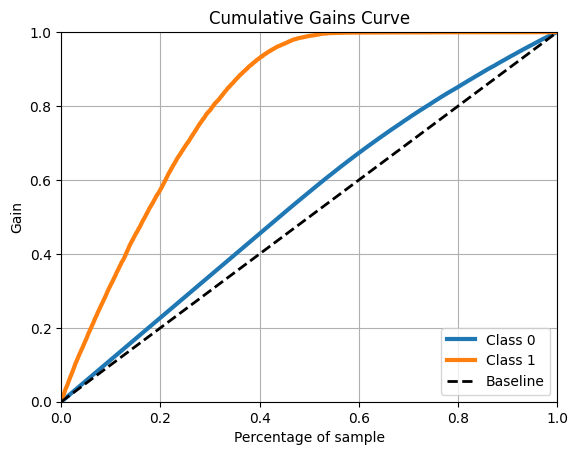

In [62]:
# Accumulative Gain
plot_cumulative_gain(y_test, lgbm_proba)
plt.show()

## 8. Model Evaluation
___

### Model Performance

In [63]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [64]:
def cross_validation(model,x_train,y_train,k, verbose=True):
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    accuracy_balanced_list = []
    precision_k_list = [] 
    recall_k_list = []  
    auc_roc_list = []
    top_k_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_proba = model.predict_proba(x_val_fold)

        # Create data to make the precision and recall k
        data = pd.DataFrame()
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        data = data.sort_values('score',ascending=False)
        
        knum = y_val_fold.value_counts().count()-1
        
        # ROC AUC SCORE
        auc_roc = roc_auc_score(y_val_fold, yhat_proba[:, 1])
        auc_roc_list.append(auc_roc)
        
        # TOP K SCORE
        top_k = top_k_accuracy_score(y_val_fold,yhat_model,k=knum)
        top_k_list.append(top_k)
        
        # Balanced Accuracy
        accuracy_balanced = balanced_accuracy_score(y_val_fold,yhat_model)
        accuracy_balanced_list.append(accuracy_balanced)
        
        # Precision at K
        precision_k = precision_at_k(data,20000)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data,20000)
        recall_k_list.append(recall_k)
        i = i + 1
        
    df = pd.DataFrame({'Model Name': type(model).__name__,
                       'Accuracy Balanced': np.mean(accuracy_balanced_list),
                       'Precision @K Mean': np.mean(precision_k_list),
                       'Recall @K Mean': np.mean(recall_k_list),
                       'ROC AUC Score': np.mean(auc_roc_list),
                       'Top K Score': np.mean(top_k_list) },index = [0])
    return df    

In [67]:
lr_cv = cross_validation(lg, x_train, y_train, 5, verbose=False)
rf_cv = cross_validation(rf, x_train, y_train, 5, verbose=False)
xgb_cv = cross_validation(xgb, x_train, y_train, 5, verbose=False)
lgbm_cv = cross_validation(lgbm, x_train, y_train, 5, verbose=False)

[LightGBM] [Info] Number of positive: 24256, number of negative: 174486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 198742, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122048 -> initscore=-1.973180
[LightGBM] [Info] Start training from score -1.973180
[LightGBM] [Info] Number of positive: 24257, number of negative: 174485
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 198742, number of used features: 9
[LightGBM] [Info] 

In [68]:
model_performance_cv = pd.concat([lr_cv, rf_cv, xgb_cv, lgbm_cv])
model_performance_cv.sort_values('ROC AUC Score', ascending=False)

,Model Name,Accuracy Balanced,Precision @K Mean,Recall @K Mean,ROC AUC Score,Top K Score
0,LGBMClassifier,0.504510,0.280886,0.926421,0.855200,0.877840
0,XGBClassifier,0.517045,0.279206,0.920880,0.850569,0.875968
0,RandomForestClassifier,0.582536,0.259607,0.856238,0.800011,0.844800
0,LogisticRegression,0.515601,0.240328,0.792660,0.771975,0.872559


* I will choose the model with the best cost-benefit ratio (higher score, lower size, higher speed). Our final model is a Light Gradient Boosting Model with AUC score of 86%.

### Feature Importance

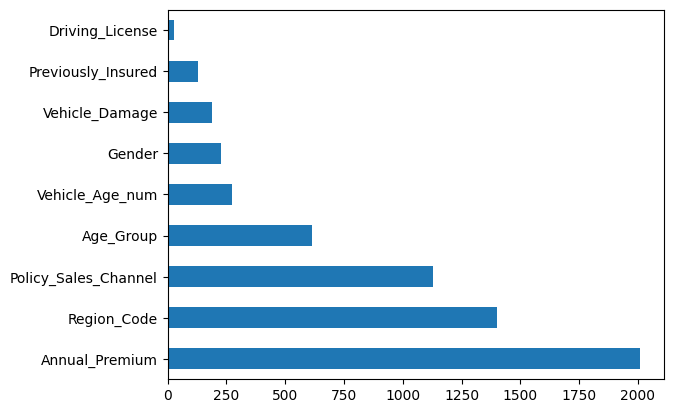

In [70]:
feat_importances = pd.Series(lgbm.feature_importances_, index = test_df.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

* Annual Premium is the most important feature in predicting whether a customer is interested in Vehicle insurance.
* Driving License is the least important feature.

## 9. Summary
___

### Key Findings

Our cross-sell analysis and predictive modeling project provide valuable insights into the dynamics of customer behavior and preferences within the context of health insurance and vehicle insurance cross-selling. Here's the summary of our analysis.

* Our analysis underscores the significance of annual premium as the most influential determinant in predicting customer interest in additional insurance products. This insight suggests the importance of tailored pricing strategies and personalized offerings to effectively target and engage potential customers. 

* Our findings highlight notable demographic trends, such as the higher interest among male customers compared to females and the age distribution of interested customers, particularly the significant proportion within the 40-49 age group. Understanding these demographic nuances is essential for refining marketing strategies and optimizing outreach efforts.

* The oberved negative correlation between age and policy sales channel preference offers valuable guidance for optimizing sales channel allocation and customer outreach strategies. By aligning outreach channels with customer preferences, insurers can enhance engagement and conversion rates.

* The utilization of a Light Gradient Boosting Model has significantly enhanced our predictive accuracy, with an impressive AUC score of 86%, indicating its robust performance in identifying potential customers interested in vehicle insurance.

### Limitations

Our analysis also reveals a weakness in the form of data imbalance, where only 12% of customers are interested in vehicle insurance. Addressing this imbalance through oversampling techniques may resolve this issue and potentially improve the overall model performance by providing more balanced representation of both interested and non-interested customers.

## 9. Conclusion
___

In conclusion, our comprehensive analysis not only provides actionable insights for optimizing cross-selling strategies but also demonstrates the efficacy of advanced modeling techniques in extracting meaningful patterns from complex datasets. These insights can empower insurers to tailor their marketing approaches, deepen customer relationships, and drive business growth in an increasingly competitive marketplace.